## Práctica 4. Procesamiento audio

### Ejercicio 1: Construir un identificador de notas musicales. Es decir; en su versión más sencilla (y suficiente) la entrada es un sonido con una sola nota musical y debe identificar cuál es. Por simplicidad elija un único instrumento para la identificación.  

(APORTES ADICIONALES)   
a) El caso más sencillo es el del piano, pero se valorará que se haga con otros instrumentos como la guitarra, la trompeta…    
b) Se valorará que se identifiquen octavas de notas

In [3]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. TABLA DE NOMBRES DE NOTAS (NOTACIÓN INTERNACIONAL)
# ----------------------------------------------------
NOTE_NAMES = ["Do", "Do#", "Re", "Re#", "Mi", "Fa",
              "Fa#", "Sol", "Sol#", "La", "La#", "Si"]

# ----------------------------------------------------
# 2. DETECCIÓN DE FRECUENCIA DOMINANTE CON FFT
# ----------------------------------------------------
def detectar_frecuencia_fft(audio_data, sample_rate,
                            min_freq=20, max_freq=None,
                            plot=False):
    """
    Detecta la frecuencia dominante de un audio usando FFT.

    audio_data : array de muestras
    sample_rate: frecuencia de muestreo (Hz)
    min_freq   : frecuencia mínima a considerar (Hz)
    max_freq   : frecuencia máxima a considerar (Hz, por defecto Nyquist)
    plot       : si True, muestra el espectro de magnitud
    """

    # Si es estéreo, pasamos a mono haciendo la media
    if audio_data.ndim == 2:
        audio_data = audio_data.mean(axis=1)

    # Convertimos a float y quitamos componente DC (media)
    audio = audio_data.astype(np.float32)
    audio = audio - np.mean(audio)

    # Ventana de Hamming para reducir fugas espectrales
    window = np.hamming(len(audio))
    audio_win = audio * window

    # FFT de solo la parte real positiva (rfft)
    N = len(audio_win)
    spectrum = np.fft.rfft(audio_win)
    freqs = np.fft.rfftfreq(N, d=1.0 / sample_rate)
    magnitude = np.abs(spectrum)

    # Limitamos el rango de búsqueda (por ejemplo, 20 Hz – Nyquist o max_freq)
    if max_freq is None:
        max_freq = sample_rate / 2

    valid = (freqs >= min_freq) & (freqs <= max_freq)

    freqs_valid = freqs[valid]
    mag_valid = magnitude[valid]

    # Índice del pico máximo en el rango válido
    idx_peak = np.argmax(mag_valid)
    freq_dominante = freqs_valid[idx_peak]

    # (Opcional) Representación gráfica del espectro
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(freqs_valid, mag_valid)
        plt.axvline(freq_dominante, linestyle="--")
        plt.xlabel("Frecuencia (Hz)")
        plt.ylabel("Magnitud")
        plt.title(f"Espectro de magnitud (pico en {freq_dominante:.2f} Hz)")
        plt.grid(True)
        plt.show()

    return freq_dominante

# ----------------------------------------------------
# 3. CONVERTIR FRECUENCIA A NOTA Y OCTAVA
# ----------------------------------------------------
def frecuencia_a_nota(f):
    """
    Convierte una frecuencia (Hz) en nota y octava usando
    afinación estándar A4 = 440 Hz.

    Devuelve:
      nombre_nota (str), octava (int), numero_midi (int)
    """

    if f <= 0:
        return None, None, None

    # Fórmula estándar: A4 (La4) es MIDI 69 y 440 Hz
    midi = int(round(69 + 12 * np.log2(f / 440.0)))

    nombre_nota = NOTE_NAMES[midi % 12]
    octava = midi // 12 - 1  # Definición usual de octava
    return nombre_nota, octava, midi


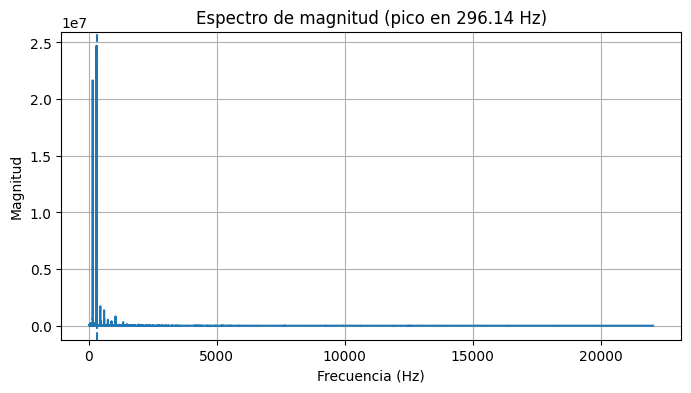

Frecuencia detectada: 296.14 Hz
Nota identificada: Re4 (MIDI 62)


In [12]:
# ----------------------------------------------------
# 4. EJEMPLO COMPLETO: LEER WAV, DETECTAR NOTA
# ----------------------------------------------------
ruta_wav = "Notas/Guitarra/guitar_re.wav"   # o trompeta, guitarra, etc.

sample_rate, audio_data = wavfile.read(ruta_wav)

freq = detectar_frecuencia_fft(audio_data, sample_rate, plot=True)
nota, octava, midi = frecuencia_a_nota(freq)

print(f"Frecuencia detectada: {freq:.2f} Hz")
print(f"Nota identificada: {nota}{octava} (MIDI {midi})")

c) Identificación de acordes (complejo pero espectacular)

In [14]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import find_peaks

# Tabla de notas (frecuencias en la 4ª octava)
NOTAS_ESP = {
    "Do": 261.63, "Do#": 277.18, "Re": 293.66, "Re#": 311.13,
    "Mi": 329.63, "Fa": 349.23, "Fa#": 369.99, "Sol": 392.00,
    "Sol#": 415.30, "La": 440.00, "La#": 466.16, "Si": 493.88
}

# Genera todas las octavas (0–8)
def generar_tabla_notas():
    tabla = {}
    for nota, f_base in NOTAS_ESP.items():
        for octava in range(0, 8):
            f = f_base * (2 ** (octava - 4))
            tabla[f"{nota}{octava}"] = f
    return tabla

TABLA_NOTAS = generar_tabla_notas()


def detectar_acorde_fft(ruta_wav, n_top=5, plot=False):
    sr, audio = wavfile.read(ruta_wav)
    if audio.ndim == 2:
        audio = audio.mean(axis=1)

    audio = audio.astype(float)
    audio -= np.mean(audio)

    window = np.hamming(len(audio))
    audio *= window

    N = len(audio)
    spectrum = np.fft.rfft(audio)
    freqs = np.fft.rfftfreq(N, 1/sr)
    mag = np.abs(spectrum)

    # Encontrar picos importantes
    peaks, _ = find_peaks(mag, height=np.max(mag)*0.1)
    freqs_picos = freqs[peaks]

    # Elegimos los n_top picos más fuertes
    picos_importantes = freqs_picos[:n_top]

    notas_detectadas = []

    for f in picos_importantes:
        # Buscar nota más cercana en las tablas
        nota_cercana = min(TABLA_NOTAS.keys(),
                           key=lambda n: abs(TABLA_NOTAS[n] - f))
        notas_detectadas.append(nota_cercana)

    return sorted(set(notas_detectadas))


# Ejemplo:
acorde = detectar_acorde_fft("acorde_CEG_A.wav")
print("Notas detectadas:", acorde)


Notas detectadas: ['Do4', 'La4', 'Mi4', 'Sol4']


### Ejercicio 2: Construir una pequeña aplicación que permita operar con diferentes filtros (con un selector) y trabajar con varios umbrales. (uno para los filtros pasa-bajo y pasa-alto y dos para los filtros pasa-banda y rechaza-banda). Demuestre su funcionalidad con señales ruidosas. Muestre en cada filtrado la señal original y filtrada en el dominio temporal y en el dominio de la frecuencia.  

(APORTES ADICIONALES)   
(a) Reproducir la nota ruidosa original y filtrada a través de la aplicación para comparar resultados y
cambiar parámetros en tiempo real (o casi).  
(b) Aportes adicionales (como uso del micrófono, experimentar con implementaciones de filtros
diferentes)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
# ------------------------------
# Filtros en frecuencia
# ------------------------------

def filtro_fft(signal, sr, tipo, f1=None, f2=None):
    """
    tipo: 'lowpass', 'highpass', 'bandpass', 'bandstop'
    f1: umbral 1
    f2: umbral 2 (solo para bandpass / bandstop)
    """
    N = len(signal)
    freq = np.fft.rfftfreq(N, 1/sr)
    spectrum = np.fft.rfft(signal)

    mask = np.ones_like(spectrum, dtype=float)

    if tipo == "lowpass":
        mask[freq > f1] = 0

    elif tipo == "highpass":
        mask[freq < f1] = 0

    elif tipo == "bandpass":
        mask[(freq < f1) | (freq > f2)] = 0

    elif tipo == "bandstop":
        mask[(freq > f1) & (freq < f2)] = 0

    spectrum_filtered = spectrum * mask
    filtered = np.fft.irfft(spectrum_filtered, n=N)

    return filtered, freq, spectrum, spectrum_filtered


# ------------------------------
# Funciones de visualización
# ------------------------------

def mostrar_temporal(original, filtrada, sr):
    t = np.arange(len(original)) / sr
    plt.figure(figsize=(12,4))
    plt.plot(t, original, label="Original", alpha=0.7)
    plt.plot(t, filtrada, label="Filtrada", alpha=0.7)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.title("Dominio temporal")
    plt.legend()
    plt.grid()
    plt.show()


def mostrar_frecuencia(freq, spectrum, spectrum_filt):
    plt.figure(figsize=(12,4))
    plt.plot(freq, np.abs(spectrum), label="Original", alpha=0.7)
    plt.plot(freq, np.abs(spectrum_filt), label="Filtrada", alpha=0.7)
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.title("Dominio frecuencial")
    plt.legend()
    plt.grid()
    plt.show()


# ------------------------------
# Ejemplo de uso sobre un audio ruidoso
# ------------------------------

ruta = "Ejemplos/senalruidosa.wav"   # Cambia por tu archivo

sr, audio = wavfile.read(ruta)

if audio.ndim == 2:
    audio = audio.mean(axis=1)

# Normalizar
audio = audio.astype(float)
audio /= np.max(np.abs(audio))


In [ ]:
from IPython.display import Audio

print("Original:")
Audio(audio, rate=sr)

Original:


#### Filtrado pasa-bajos

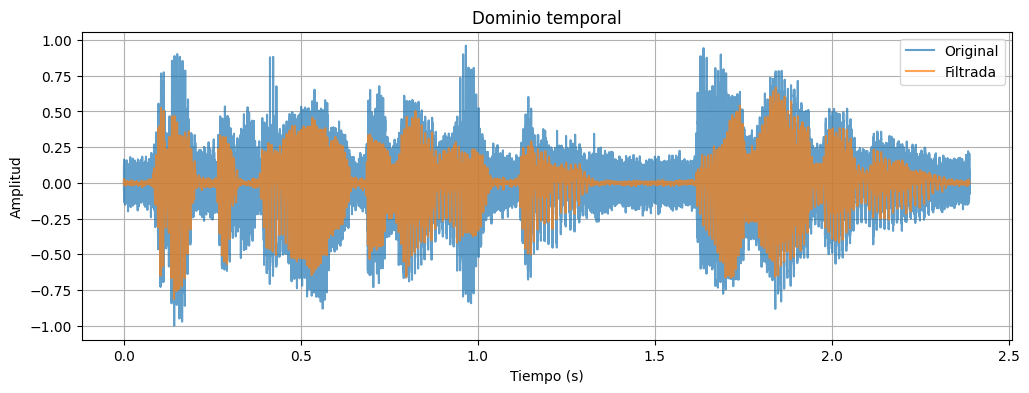

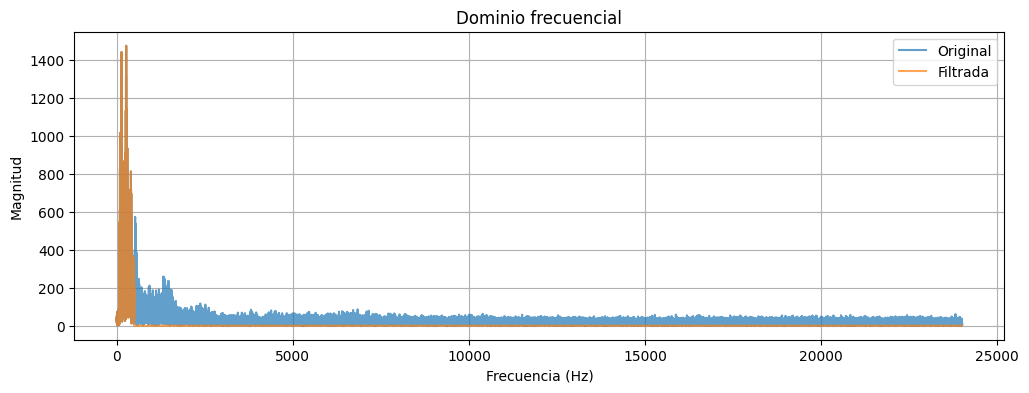

In [34]:
filtrada, freq, spec_orig, spec_filt = filtro_fft(audio, sr, "lowpass", f1=500)
mostrar_temporal(audio, filtrada, sr)
mostrar_frecuencia(freq, spec_orig, spec_filt)
Audio(filtrada, rate=sr)


Filtrado pasa-altos:


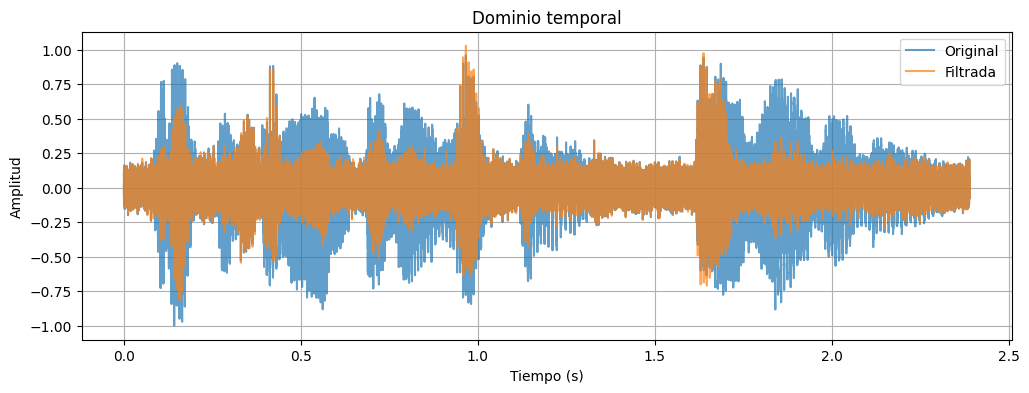

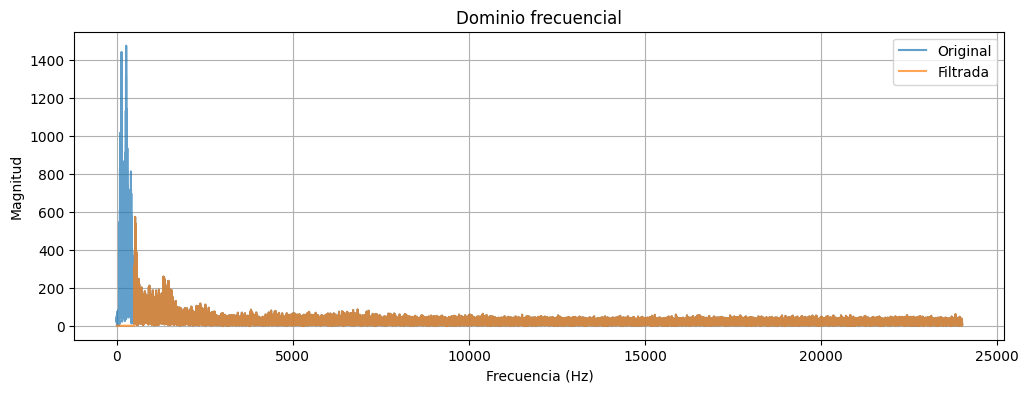

In [31]:
print("Filtrado pasa-altos:")
filtrada, freq, spec_orig, spec_filt = filtro_fft(audio, sr, "highpass", f1=500)
mostrar_temporal(audio, filtrada, sr)
mostrar_frecuencia(freq, spec_orig, spec_filt)
Audio(filtrada, rate=sr)

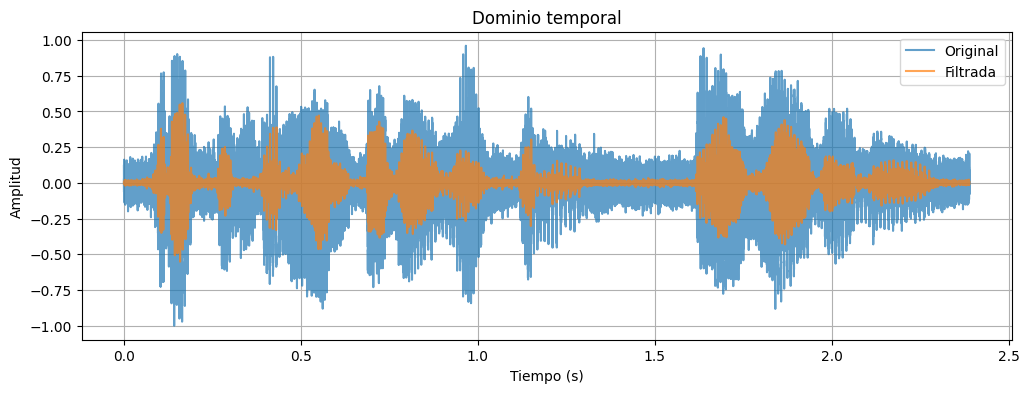

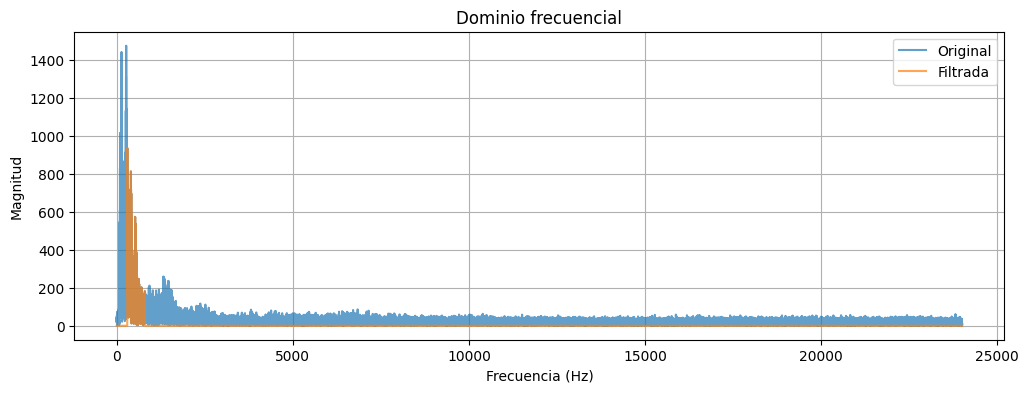

In [32]:
filtro_fft(audio, sr, "bandpass", f1=300, f2=800)
filtrada, freq, spec_orig, spec_filt = filtro_fft(audio, sr, "bandpass", f1=300, f2=800)
mostrar_temporal(audio, filtrada, sr)
mostrar_frecuencia(freq, spec_orig, spec_filt)
Audio(filtrada, rate=sr)

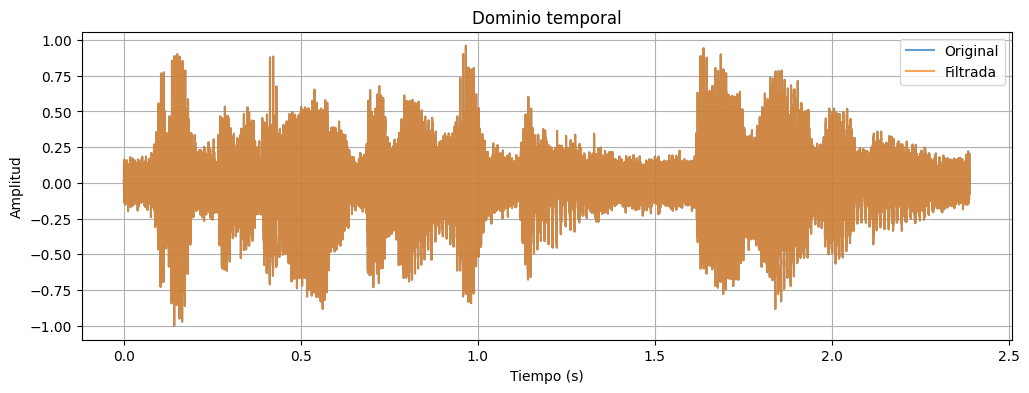

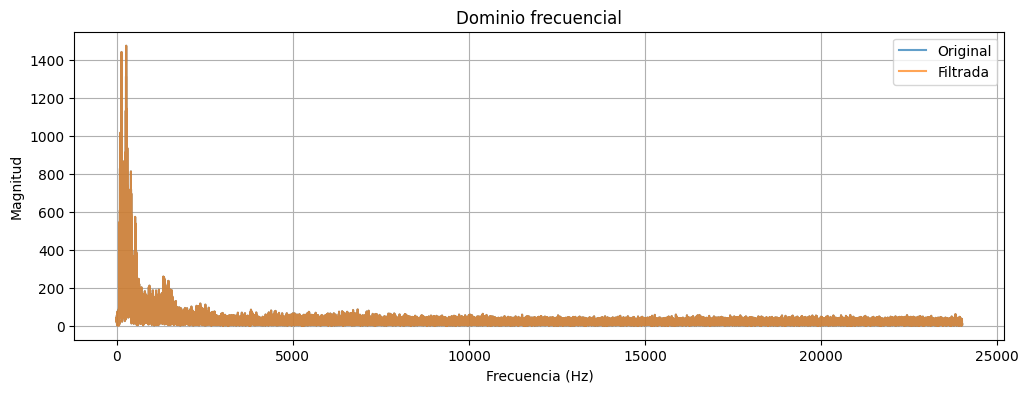

In [33]:
filtro_fft(audio, sr, "bandstop", f1=45, f2=55)
filtrada, freq, spec_orig, spec_filt = filtro_fft(audio, sr, "bandstop", f1=45, f2=55)
mostrar_temporal(audio, filtrada, sr)
mostrar_frecuencia(freq, spec_orig, spec_filt)
Audio(filtrada, rate=sr)

b) Aportes adicionales: Uso del micrófono.

In [27]:
import sounddevice as sd

dur = 2  # segundos
grabacion = sd.rec(int(sr * dur), samplerate=sr, channels=1)
sd.wait()
audio = grabacion[:,0]
Audio(audio, rate=sr)



## APLICACION

In [4]:
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import numpy as np
from scipy.io import wavfile

import sounddevice as sd   # ← PARA GRABAR Y REPRODUCIR AUDIO

import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


# ---------------------------------------------------------
# FILTRO FFT
# ---------------------------------------------------------
def aplicar_filtro_fft(audio, sr, tipo, f1=None, f2=None):
    N = len(audio)
    freqs = np.fft.rfftfreq(N, 1/sr)
    spectrum = np.fft.rfft(audio)
    mask = np.ones_like(spectrum)

    if tipo == "Pasa-bajo":
        mask[freqs > f1] = 0

    elif tipo == "Pasa-alto":
        mask[freqs < f1] = 0

    elif tipo == "Pasa-banda":
        mask[(freqs < f1) | (freqs > f2)] = 0

    elif tipo == "Rechaza-banda":
        mask[(freqs > f1) & (freqs < f2)] = 0

    spec_filt = spectrum * mask
    filtrada = np.fft.irfft(spec_filt, n=N)

    return filtrada, freqs, spectrum, spec_filt



# ---------------------------------------------------------
# APLICACIÓN
# ---------------------------------------------------------
class AppFiltros:

    def __init__(self, root):
        self.root = root
        self.root.title("Aplicación de filtros FFT")

        self.audio = None
        self.filtrada_actual = None
        self.sr = 44100
        self.nyquist = self.sr / 2

        # variables para grabación
        self.grabando = False
        self.buffer_grabacion = []


        # ------------------- CARGAR AUDIO -------------------
        ttk.Button(root, text="Cargar audio", command=self.cargar_audio).pack(pady=10)

        # ------------------- GRABAR AUDIO -------------------
        frame_rec = ttk.Frame(root)
        frame_rec.pack(pady=5)

        ttk.Button(frame_rec, text="🎤 Grabar", command=self.iniciar_grabacion).grid(row=0, column=0, padx=5)
        ttk.Button(frame_rec, text="⏹ Finalizar", command=self.finalizar_grabacion).grid(row=0, column=1, padx=5)

        # ------------------- SELECTOR DE FILTRO -------------------
        ttk.Label(root, text="Filtro:").pack()
        self.selector_filtro = ttk.Combobox(
            root,
            values=["Pasa-bajo", "Pasa-alto", "Pasa-banda", "Rechaza-banda"]
        )
        self.selector_filtro.current(0)
        self.selector_filtro.bind("<<ComboboxSelected>>", self.actualizar_sliders)
        self.selector_filtro.pack()

        # ------------------- SLIDER F1 -------------------
        self.label_f1 = ttk.Label(root, text="Umbral 1 (Hz):")
        self.label_f1.pack()
        self.slider_f1 = tk.Scale(root, from_=0, to=self.nyquist,
                                  orient="horizontal", length=300)
        self.slider_f1.pack()

        # ------------------- SLIDER F2 -------------------
        self.label_f2 = ttk.Label(root, text="Umbral 2 (Hz):")
        self.label_f2.pack()
        self.slider_f2 = tk.Scale(root, from_=0, to=self.nyquist,
                                  orient="horizontal", length=300)
        self.slider_f2.pack()
        self.slider_f2.config(state="disabled")

        # ------------------- APLICAR FILTRO -------------------
        ttk.Button(root, text="Aplicar filtro", command=self.procesar).pack(pady=15)

        # ------------------- REPRODUCTORES -------------------
        frame_audio = ttk.Frame(root)
        frame_audio.pack(pady=10)

        ttk.Button(frame_audio, text="▶ Reproducir Original",
                   command=self.reproducir_original).grid(row=0, column=0, padx=10)

        ttk.Button(frame_audio, text="▶ Reproducir Filtrada",
                   command=self.reproducir_filtrada).grid(row=0, column=1, padx=10)

        # ------------------- GRAFICAS -------------------
        self.fig, self.axs = plt.subplots(2, 1, figsize=(10, 6))
        self.canvas = FigureCanvasTkAgg(self.fig, master=root)
        self.canvas.get_tk_widget().pack()


    # ======================================================
    # CARGAR AUDIO DESDE ARCHIVO
    # ======================================================
    def cargar_audio(self):
        ruta = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
        if not ruta:
            return

        self.sr, audio = wavfile.read(ruta)
        if audio.ndim == 2:
            audio = audio.mean(axis=1)

        audio = audio.astype(float)
        audio /= np.max(np.abs(audio))

        self.audio = audio
        self.filtrada_actual = None
        self.nyquist = self.sr / 2

        self.slider_f1.config(to=self.nyquist)
        self.slider_f2.config(to=self.nyquist)

        messagebox.showinfo("OK", "Audio cargado correctamente.")


    # ======================================================
# GRABACIÓN DE AUDIO - FIX PARA MACOS
# ======================================================
    def iniciar_grabacion(self):
        self.buffer_grabacion = []
        self.grabando = True

        sd.default.samplerate = self.sr
        sd.default.channels = 1

        # GUARDAMOS EL STREAM PARA EVITAR SEGFAULT
        self.stream = sd.InputStream(callback=self.callback_grabacion)
        self.stream.start()

        messagebox.showinfo("Grabando", "Grabación iniciada...")


    def callback_grabacion(self, indata, frames, time, status):
        if self.grabando:
            self.buffer_grabacion.append(indata.copy())


    def finalizar_grabacion(self):
        if not self.grabando:
            return

        self.grabando = False

        # DETENER STREAM SIN SEGFAULT
        if hasattr(self, "stream") and self.stream is not None:
            self.stream.stop()
            self.stream.close()
            self.stream = None

        if not self.buffer_grabacion:
            messagebox.showerror("Error", "No se ha grabado nada.")
            return

        audio = np.concatenate(self.buffer_grabacion, axis=0).flatten()
        audio /= np.max(np.abs(audio))  # normalizar

        self.audio = audio
        self.filtrada_actual = None

        messagebox.showinfo("OK", "Grabación finalizada y cargada.")



    # ======================================================
    # REPRODUCTORES
    # ======================================================
    def reproducir_original(self):
        if self.audio is None:
            messagebox.showerror("Error", "No hay audio cargado.")
            return
        sd.play(self.audio, self.sr)


    def reproducir_filtrada(self):
        if self.filtrada_actual is None:
            messagebox.showerror("Error", "Primero aplica un filtro.")
            return
        sd.play(self.filtrada_actual, self.sr)


    # ======================================================
    def actualizar_sliders(self, event=None):
        tipo = self.selector_filtro.get()
        if tipo in ["Pasa-banda", "Rechaza-banda"]:
            self.slider_f2.config(state="normal")
        else:
            self.slider_f2.config(state="disabled")


    # ======================================================
    # APLICAR FILTRO
    # ======================================================
    def procesar(self):
        if self.audio is None:
            messagebox.showerror("Error", "Primero carga o graba un audio.")
            return

        tipo = self.selector_filtro.get()
        f1 = float(self.slider_f1.get())
        f2 = float(self.slider_f2.get()) if tipo in ["Pasa-banda", "Rechaza-banda"] else None

        if f2 is not None and f2 <= f1:
            messagebox.showerror("Error", "Umbral 2 debe ser mayor que Umbral 1.")
            return

        filtrada, freqs, spec_orig, spec_filt = aplicar_filtro_fft(
            self.audio, self.sr, tipo, f1, f2
        )

        self.filtrada_actual = filtrada

        # ---- ACTUALIZAR GRAFICAS ---
        self.axs[0].clear()
        self.axs[1].clear()

        # Temporal
        t = np.arange(len(self.audio)) / self.sr
        self.axs[0].plot(t, self.audio, label="Original")
        self.axs[0].plot(t, filtrada, label="Filtrada")
        self.axs[0].set_title("Dominio temporal")
        self.axs[0].legend()
        self.axs[0].grid()

        # Frecuencia
        self.axs[1].plot(freqs, np.abs(spec_orig), label="Original")
        self.axs[1].plot(freqs, np.abs(spec_filt), label="Filtrada")
        self.axs[1].set_title("Dominio frecuencial")
        self.axs[1].legend()
        self.axs[1].grid()

        self.fig.tight_layout()
        self.canvas.draw()
    
    def cerrar_app(self):
        print("Cerrando app…")

        # 1. Cerrar stream de grabación (si existe)
        self.grabando = False
        if hasattr(self, "stream") and self.stream is not None:
            try:
                self.stream.stop()
                self.stream.close()
            except:
                pass
            self.stream = None

        # 2. Parar sonido
        try:
            sd.stop()
        except:
            pass

        # 3. Cerrar figura de matplotlib ← ← ← ESTA ES LA CLAVE
        try:
            plt.close(self.fig)
            print("Figura de Matplotlib cerrada.")
        except:
            pass

        # 4. Destruir ventana Tk
        self.root.destroy()

        # 5. Para macOS: terminar proceso Cocoa
        import sys
        sys.exit(0)

    


        






# ---------------------------------------------------------
# EJECUTAR
# ---------------------------------------------------------
root = tk.Tk()
app = AppFiltros(root)

# Cuando se pulse la X, llamar a cerrar_app()
root.protocol("WM_DELETE_WINDOW", app.cerrar_app)

root.mainloop()



Cerrando app…
Figura de Matplotlib cerrada.


SystemExit: 0


    while executing
"4747820224cerrar_app"
    (command for "WM_DELETE_WINDOW" window manager protocol)
